# Investigating the best measure for the concrete dataset

In [101]:
%run imports.py

seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [103]:
def concrete_data():

    concrete = fetch_ucirepo(id=165)

    df = concrete.data.features.copy()
    df = df.select_dtypes(include='number')
    y_target = concrete.data.targets.copy()

    X = df.to_numpy()
    y = y_target.to_numpy()
    y = y.reshape(-1, 1)

    # Create training and testing data split:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data

In [105]:
def autompg_data():

    auto_mpg = fetch_ucirepo(id=9)

    X_df = auto_mpg.data.features.copy()
    y_df = auto_mpg.data.targets.copy()

    X_df['horsepower'] = pd.to_numeric(X_df['horsepower'], errors='coerce')
    
    horsepower_median = X_df['horsepower'].median()
    X_df['horsepower'].fillna(horsepower_median, inplace=True)
    
    if 'car name' in X_df.columns:
      X_df = X_df.drop('car name', axis=1)
    elif 'car-name' in X_df.columns:
      X_df = X_df.drop('car-name', axis=1)
    
    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data

In [107]:
def boston_housing_data():

    filepath = 'BostonHousing.csv'


    if not os.path.exists(filepath):
        raise FileNotFoundError(
            f"Error: The file '{filepath}' was not found in the current directory."
        )
    
    df = pd.read_csv(filepath)
    df = df[df['medv'] < 50.0] # Remove outliers

    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1]


    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data


In [109]:
def fake_data():

    X = np.random.normal(loc=0, scale=1, size=(500,4))
    y = X[:,0]*X[:,1]*X[:,2]*X[:,3]

    y = y.reshape(-1,1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data

In [110]:
def train_model_nf(X_train, y_train):

    data = (X_train, y_train)
    interact = 4
    
    print("Training NF")
    oak = create_model_oak(
                data=data,
                max_interaction_depth=interact,
                constrain_orthogonal=True,
                share_var_across_orders=True,
                use_sparsity_prior=False,
                lengthscale_bounds=[1e-3, 1e3] 
    )

    for i in range(interact):
        oak.kernel.variances[i].assign(1/(math.comb(interact,i)))

    # --- Train model ---
    opt = gpflow.optimizers.Scipy()
    opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

    #print(oak.training_loss().numpy())

    # --- Perturb inputs and find the minimum NMLL of the runs ---
    num_perturbations = 10
    best_model = gpflow.utilities.deepcopy(oak)
    
    for _ in range(num_perturbations):
        
        model_copy = gpflow.utilities.deepcopy(best_model)
        model = model_perturbation(model_copy, interact)
        
        if model.training_loss().numpy() < best_model.training_loss().numpy():
            best_model = gpflow.utilities.deepcopy(model)

    oak = best_model
    #gpflow.utilities.print_summary(oak)
    #print(oak.training_loss().numpy())

    K_oak = oak.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * oak.likelihood.variance.numpy()
    alpha_oak = tf.linalg.solve(K_oak, tf.convert_to_tensor(y_train, dtype=tf.float64))
    oak_datafit = 0.5 * y_train.T@alpha_oak
    L = tf.linalg.cholesky(K_oak)
    oak_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L))).numpy()
    
    return oak, oak_datafit, oak_complexity

In [113]:
def train_model(X_train, y_train, gmm_measures_list = None, empirical_locations_list = None, empirical_weights_list = None):

    data = (X_train, y_train)
    interact = 4
    

    if gmm_measures_list != None:
        print("Training Mixture of Gaussians model!")
        oak = create_model_oak(
              data=data,
              max_interaction_depth=interact,
              constrain_orthogonal=True,
              share_var_across_orders=True,
              use_sparsity_prior=False,
              gmm_measures=gmm_measures_list,
              lengthscale_bounds=[1e-3, 1e3] 
        )

        # --- Initialise Variances ---
        for i in range(interact):
            oak.kernel.variances[i].assign(1/(math.comb(interact,i)))
            oak.kernel.kernels[i].base_kernel.variance.assign(1.0)
            gpflow.set_trainable(oak.kernel.kernels[i].base_kernel.variance, False)

    else:
        print("Training Empirical model!")
        oak = create_model_oak(
              data=data,
              max_interaction_depth=interact,
              constrain_orthogonal=True,
              share_var_across_orders=True,
              use_sparsity_prior=False,
              empirical_locations=empirical_locations_list,
              empirical_weights=empirical_weights_list,
              lengthscale_bounds=[1e-3, 1e3] 
        )

        # --- Initialise Variances ---
        for i in range(interact):
            oak.kernel.variances[i].assign(1/(math.comb(interact,i)))
            oak.kernel.kernels[i].base_kernel.variance.assign(1.0)
            gpflow.set_trainable(oak.kernel.kernels[i].base_kernel.variance, False)


    # --- Train model ---
    opt = gpflow.optimizers.Scipy()
    opt.minimize(oak.training_loss, oak.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

    #print(oak.training_loss().numpy())

    # --- Perturb inputs and find the minimum NMLL of the runs ---
    num_perturbations = 10
    best_model = gpflow.utilities.deepcopy(oak)
    
    for _ in range(num_perturbations):
        
        model_copy = gpflow.utilities.deepcopy(best_model)
        model = model_perturbation(model_copy, interact)

        for j in range(interact):
            model.kernel.kernels[j].base_kernel.variance.assign(1.0)
            gpflow.set_trainable(model.kernel.kernels[j].base_kernel.variance, False)
        
        if model.training_loss().numpy() < best_model.training_loss().numpy():
            best_model = gpflow.utilities.deepcopy(model)

    oak = best_model
    #print(oak.training_loss().numpy())

    K_oak = oak.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * oak.likelihood.variance.numpy()
    alpha_oak = tf.linalg.solve(K_oak, tf.convert_to_tensor(y_train, dtype=tf.float64))
    oak_datafit = 0.5 * y_train.T@alpha_oak
    L = tf.linalg.cholesky(K_oak)
    oak_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L))).numpy()
    
    return oak, oak_datafit, oak_complexity

In [114]:
def model_perturbation(model, max_interact):

    def positive_or_negative():
        if np.random.rand() < 0.5:
            return 1
        else:
            return -1

    for i in range(max_interact):
        bk_ls = model.kernel.kernels[i].base_kernel.lengthscales.numpy()
        new_ls = bk_ls + 0.1*positive_or_negative()*bk_ls + 1e-6

        low_bound = model.kernel.kernels[i].base_kernel.lengthscales.transform.low
        high_bound = model.kernel.kernels[i].base_kernel.lengthscales.transform.high

        clipped_ls = np.clip(new_ls, low_bound + 1e-6, high_bound - 1e-6)
        
        model.kernel.kernels[i].base_kernel.lengthscales.assign(clipped_ls)
        
        bk_sv = model.kernel.variances[i].numpy()
        new_variance = bk_sv + 0.1*positive_or_negative()*bk_sv + 1e-6
        model.kernel.variances[i].assign(new_variance)
        
    bk_sv = model.kernel.variances[max_interact].numpy()
    model.kernel.variances[max_interact].assign(bk_sv + 0.1*positive_or_negative()*bk_sv)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

    return model

In [117]:
def gaussian_calculation(X_train):

    custom_measure = []

    for i in range(X_train.shape[1]):
        data_dim = X_train[:,i]
        mu_i = np.mean(data_dim)
        var_i = np.var(data_dim)
        custom_measure.append(MOGMeasure(means=np.array([mu_i]), variances=np.array([var_i]), weights=np.array([1.0])))

    return custom_measure

In [119]:
def mog_calculation(X_train):

    gmm_measures_list = []

    for i in range(X_train.shape[1]):
        data_dim = X_train[:,i].reshape(-1,1)
        n_components_arr = range(1,11)
        bic_scores = []

        for n_components in n_components_arr:
            gmm = GaussianMixture(n_components=n_components, covariance_type="spherical")
            gmm.fit(data_dim)
            bic_scores.append(gmm.bic(data_dim))

        best_k = n_components_arr[np.argmin(bic_scores)]
        gmm_measures_list.append(estimate_one_dim_gmm(K=best_k, X=data_dim.flatten()))

    return gmm_measures_list

In [121]:
def empirical_calculation(X_train):

    empirical_locations_list = []
    empirical_weights_list = []

    for dim in range(X_train.shape[1]):
        locations, counts = np.unique(X_train[:, dim], return_counts=True)
        weights = (counts / counts.sum()).reshape(-1, 1)
        locations = locations.reshape(-1, 1)
    
        empirical_locations_list.append(locations)
        empirical_weights_list.append(weights)

    return empirical_locations_list, empirical_weights_list

In [122]:
def test_metrics(model, X_test, y_test_standardized, y_mean, y_std):

    y_pred_standardized, f_var = model.predict_f(X_test)

    sq_error = (y_test_standardized - y_pred_standardized)**2

    y_var = f_var + model.likelihood.variance
    y_var = tf.maximum(y_var, 1e-6)
    pred_dist = tfp.distributions.Normal(loc=y_pred_standardized, scale=tf.sqrt(y_var))
    log_prob = pred_dist.log_prob(y_test_standardized)
    nll_model = -tf.reduce_mean(log_prob)

    y_pred_original = (y_pred_standardized * y_std) + y_mean
    y_test_original = (y_test_standardized * y_std) + y_mean

    rmse_model = mean_squared_error(y_test_original, y_pred_original, squared=False)
    
    training_nmll = model.training_loss().numpy()

    return training_nmll, nll_model.numpy(), rmse_model

In [125]:
def standard_gaussian(X_train):
    custom_measure = MOGMeasure(means=np.array([0.0]), variances=np.array([1.0]), weights=np.array([1.0]))
    gmm_measure_list = [custom_measure for i in range(X_train.shape[1])]
    return gmm_measure_list

In [126]:
def standard_mog(X_train):
    custom_measure = MOGMeasure(means=np.array([-1.0, 1.0]), variances=np.array([1.0, 1.0]), weights=np.array([0.5, 0.5]))
    gmm_measure_list = [custom_measure for i in range(X_train.shape[1])]
    return gmm_measure_list

In [127]:
def calculate_mog_pdf(measure, x):
    
    total_pdf = np.zeros_like(x, dtype=float)
    x_flat = x.flatten()

    for mean, var, weight in zip(measure.means, measure.variances, measure.weights):
        std_dev = np.sqrt(var)
        total_pdf += weight * norm.pdf(x_flat, loc=mean, scale=std_dev)
        
    return total_pdf

In [128]:
def visualise_fit(X_train, gmm_measure_list):

    fig, axes = plt.subplots(1, X_train.shape[1], figsize=(10*X_train.shape[1], 8))

    for i in range(X_train.shape[1]):
        X_dim = X_train[:,i]
        xvals = np.linspace(X_dim.min(), X_dim.max(), 100)
        gmm_pdf = calculate_mog_pdf(gmm_measure_list[i], xvals)

        sns.histplot(X_dim, stat='density', kde=False, bins=50, label='Data Distribution', ax=axes[i])
        axes[i].plot(xvals, gmm_pdf, color='red', linestyle='--', label='MoG Measure', linewidth=3)
        axes[i].set_title('Distribution of GTEP')
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=16)


    plt.tight_layout()
    plt.show()

In [133]:
def sobol_by_order(model):

    tuple_of_indices, sobols = compute_sobol_oak_with_mog(model,share_var_across_orders=True)
    normalised_sobols = sobols / np.sum(sobols)

    sobol_by_order = np.zeros(interact)
    
    for indices, sobol_value, normalised_sobol in zip(tuple_of_indices, sobols, normalised_sobols):
        sobol_by_order[len(indices)-1] += normalised_sobol

    return sobol_by_order

In [135]:
def nf_data(X_train, X_test):

    seed =4
    np.random.seed(seed)
    tf.random.set_seed(seed)

    num_dims = X_train.shape[1]
    input_flows = [None] * num_dims
    X_transformed = np.zeros_like(X_train)

    
    for i in range(num_dims):
    
        # Extract the 1D data for the current dimension
        d = X_train[:, i]
    
        # Initialize the Normalizer. log=False is safer for data centered at 0.
        n_flow = Normalizer(d, log=False)
    
        # Train the flow by minimizing the KL divergence objective
        opt_flow = gpflow.optimizers.Scipy()
        opt_flow.minimize(n_flow.KL_objective, n_flow.trainable_variables)
    
        # Store the trained flow and apply the transformation
        input_flows[i] = n_flow
        transformed_data_1d = n_flow.bijector(d).numpy()
        X_transformed[:, i] = transformed_data_1d

    
    X_test_transformed = np.zeros_like(X_test)
    
    for i in range(num_dims):
        
        n_flow = input_flows[i]
        X_test_transformed[:, i] = n_flow.bijector(X_test[:, i]).numpy()

    return X_transformed, X_test_transformed


In [137]:
def calculate_rmse(y_true, y_pred):
    
    return mean_squared_error(y_true, y_pred, squared=False)

In [139]:
def plot_parsimony_analysis(
    model: gpflow.models.GPR,
    X_test: np.ndarray,
    y_test: np.ndarray,
    y_mean: float,
    y_std: float,
    title: str = "Model Parsimony Analysis"
) -> tuple[np.ndarray, np.ndarray]:
    """
    Ranks model components by Sobol indices and plots the cumulative Sobol 
    index and model RMSE as components are added one by one.
    """
    tuple_of_indices, sobols = compute_sobol_oak_with_mog(model, share_var_across_orders=True)
    sobols = np.array(sobols)
    
    ranked_indices = np.argsort(sobols)[::-1]
    ranked_sobols = sobols[ranked_indices]
    ranked_components = [tuple_of_indices[i] for i in ranked_indices]

    normalised_sobols = ranked_sobols / np.sum(sobols)
    cumulative_sobol = np.cumsum(normalised_sobols)
    
    print(f"Found {len(ranked_components)} components. Most important: {ranked_components[0]} with Sobol {normalised_sobols[0]:.4f}")

    
    rmse_values = []
    num_components = len(ranked_components)

    alpha = get_model_sufficient_statistics(model, get_L=False)
    
    if isinstance(model, gpflow.models.GPR):
        X_conditioned = model.data[0]
    else:
        X_conditioned = model.inducing_variable.Z

    kernel_const = KernelComponenent(model.kernel, [])
    
    # Initialize the cumulative kernel matrix with the constant term's kernel matrix
    K_cumulative = kernel_const(X_test, X_conditioned).numpy()

    for k in range(num_components):
        # Get the next most important component
        component_indices = ranked_components[k]
        
        # Create a kernel for this single component
        kernel_comp = KernelComponenent(model.kernel, component_indices)
        
        # Calculate its kernel matrix and add it to our cumulative kernel
        K_component = kernel_comp(X_test, X_conditioned).numpy()
        K_cumulative += K_component

        # Predict using the full cumulative kernel
        y_pred_k = tf.matmul(K_cumulative, alpha).numpy()

        # Un-standardize the cumulative predictions to calculate the true RMSE
        y_pred_unscaled = (y_pred_k * y_std) + y_mean
        y_test_unscaled = (y_test * y_std) + y_mean
        
        rmse = calculate_rmse(y_test_unscaled, y_pred_unscaled)
        rmse_values.append(rmse)
        
        if (k + 1) % 10 == 0 or (k + 1) == num_components:
            print(f"  Evaluated model with constant + {k+1}/{num_components} terms. Test RMSE: {rmse:.4f}")

    print(f"Final RMSE with all components: {rmse_values[-1]:.4f}")

    return cumulative_sobol, np.array(rmse_values)

In [141]:
def plot_parsimony_all_runs(all_sobols: list, all_rmses: list, title: str):
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    color = 'darkred'
    ax1.set_xlabel('Number of Terms Added (ranked by importance)')
    ax1.set_ylabel('Test RMSE', color=color)
    for i, rmse_vals in enumerate(all_rmses):
        ax1.plot(range(1, len(rmse_vals) + 1), rmse_vals, color=color, alpha=0.4, label=f'Run {i+1}' if i==0 else "")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'cornflowerblue'
    ax2.set_ylabel('Cumulative Sobol Index', color=color)
    for i, sobol_vals in enumerate(all_sobols):
        ax2.plot(range(1, len(sobol_vals) + 1), sobol_vals, color=color, linestyle='--', alpha=0.4, label=f'Run {i+1}' if i==0 else "")
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1.05)

    plt.yscale('log')
    fig.tight_layout()
    plt.title(title)
    plt.grid(True, linestyle=':')
    plt.show()




def plot_parsimony_individual_runs(all_sobols: list, all_rmses: list, title: str):

    for i, (rmse_vals, sobol_vals) in enumerate(zip(all_rmses, all_sobols)):
        
        fig, ax1 = plt.subplots(figsize=(12, 7))
        
        color_rmse = 'darkred'
        ax1.set_xlabel('Number of Terms Added (ranked by importance)')
        ax1.set_ylabel('Test RMSE', color=color_rmse)
        ax1.plot(
            range(1, len(rmse_vals) + 1), 
            rmse_vals, 
            color=color_rmse, 
            marker='o', 
            markersize=4, 
            linestyle='-'
        )
        ax1.tick_params(axis='y', labelcolor=color_rmse)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color_sobol = 'cornflowerblue'
        ax2.set_ylabel('Cumulative Sobol Index', color=color_sobol)
        ax2.plot(
            range(1, len(sobol_vals) + 1), 
            sobol_vals, 
            color=color_sobol, 
            marker='x', 
            markersize=5, 
            linestyle='--'
        )
        ax2.tick_params(axis='y', labelcolor=color_sobol)
        ax2.set_ylim(0, 1.05)
        
        plt.title(f"{title} Run {i+1})")
        plt.xlim(0, 55)
        plt.grid(True, linestyle=':')
        fig.tight_layout()
        filename = f"{title.replace(' ', '_').lower()}{i+1}.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        

def plot_parsimony_average(all_sobols: list, all_rmses: list, title: str, savefig: str):

    max_len = 0
    if all_sobols:
        max_len = max(len(s) for s in all_sobols)
    if all_rmses:
        max_len = max(max_len, max(len(r) for r in all_rmses))
    
    if max_len == 0:
        print("Warning: No data to plot.")
        return

    padded_rmses = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rmses]
    padded_sobols = [np.pad(s, (0, max_len - len(s)), 'constant', constant_values=1.0) for s in all_sobols]
    
    # Calculate mean and standard deviation
    mean_rmse = np.mean(padded_rmses, axis=0)
    std_rmse = np.std(padded_rmses, axis=0)
    
    mean_sobol = np.mean(padded_sobols, axis=0)
    std_sobol = np.std(padded_sobols, axis=0)
    
    x_axis = range(1, max_len + 1)
    
    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(12, 7))
    
    # Plot Average RMSE with std deviation band
    color_rmse = 'darkred'
    ax1.set_xlabel('Number of Terms Added (ranked by importance)', fontsize=25)
    ax1.set_ylabel('Average Test RMSE', color=color_rmse, fontsize=25)
    p1 = ax1.plot(x_axis, mean_rmse, color=color_rmse, marker='o', markersize=3, linestyle='-', label='Mean RMSE')[0]
    f1 = ax1.fill_between(x_axis, mean_rmse - std_rmse, mean_rmse + std_rmse, color=color_rmse, alpha=0.2, label='RMSE Std. Dev.')
    ax1.tick_params(axis='y', labelcolor=color_rmse)
    ax1.set_xlim(0,95)

    # Plot Average Cumulative Sobol with std deviation band
    ax2 = ax1.twinx()
    color_sobol = 'cornflowerblue'
    ax2.set_ylabel('Average Cumulative Sobol Index', color=color_sobol, fontsize=25)
    p2 = ax2.plot(x_axis, mean_sobol, color=color_sobol, marker='x', markersize=4, linestyle='--', label='Mean Cumulative Sobol')[0]
    f2 = ax2.fill_between(x_axis, mean_sobol - std_sobol, mean_sobol + std_sobol, color=color_sobol, alpha=0.2, label='Sobol Std. Dev.')
    ax2.tick_params(axis='y', labelcolor=color_sobol)
    ax2.set_ylim(0, 1.05)
    ax2.set_xlim(0,55)
    
    handles = [p1, f1, p2, f2]
    labels = [h.get_label() for h in handles]
    
    # Create a single legend for the entire figure
    ax2.legend(handles, labels, loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9, fontsize=18)
    
    fig.tight_layout()
    plt.title(title, fontsize=35)
    plt.grid(True, linestyle=':')
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

In [143]:
def compute_sobol_oak_with_mog(model: gpflow.models.BayesianModel, share_var_across_orders: bool = True):
    """
    Modified version of compute_sobol_oak that handles MOGMeasure with a single Gaussian for Sobol calculation.
    """
    assert isinstance(model.kernel, OAKKernel), "only work for OAK kernel"
    num_dims = model.data[0].shape[1]

    selected_dims_oak, kernel_list = get_list_representation(
        model.kernel, num_dims=num_dims
    )
    selected_dims_oak = selected_dims_oak[1:]  # skip constant term
    if isinstance(model, (gpflow.models.SGPR, gpflow.models.SVGP)):
        X = model.inducing_variable.Z
    else:
        X = model.data[0]
    N = X.shape[0]
    alpha = get_model_sufficient_statistics(model, get_L=False)
    sobol = []
    L_list = []
    for kernel in kernel_list:
        assert isinstance(kernel, KernelComponenent)
        if len(kernel.iComponent_list) == 0:
            continue
        L = np.ones((N, N))
        n_order = len(kernel.kernels)
        for j in range(len(kernel.kernels)):
            if share_var_across_orders:
                v = kernel.oak_kernel.variances[n_order].numpy() if j < 1 else 1
            else:
                v = kernel.kernels[j].base_kernel.variance.numpy()

            dim = kernel.kernels[j].active_dims[0]

            if isinstance(kernel.kernels[j], OrthogonalRBFKernel):
                l = kernel.kernels[j].base_kernel.lengthscales.numpy()

                if isinstance(kernel.kernels[j].measure, MOGMeasure):
                    # Handle MOGMeasure by extracting mu and delta
                    if len(kernel.kernels[j].measure.means) == 1:
                        mu = kernel.kernels[j].measure.means[0]
                        delta = np.sqrt(kernel.kernels[j].measure.variances[0])
                        L = L * compute_L(X, l, v, dim, delta, mu)
                    else:
                        raise NotImplementedError("Sobol for multi-component MOG is not implemented.")

                elif isinstance(kernel.kernels[j].measure, EmpiricalMeasure):
                     L = (
                        v ** 2
                        * L
                        * compute_L_empirical_measure(
                            kernel.kernels[j].measure.location,
                            kernel.kernels[j].measure.weights,
                            kernel.kernels[j],
                            tf.reshape(X[:, dim], [-1, 1]),
                        )
                    )
                else:
                    mu_default = 0.0
                    delta_default = 1.0
                    L = L * compute_L(X,l,v,dim,delta_default,mu_default)


            elif isinstance(kernel.kernels[j], OrthogonalBinary):
                p0 = kernel.kernels[j].p0
                L = L * compute_L_binary_kernel(X, p0, v, dim)

            elif isinstance(kernel.kernels[j], OrthogonalCategorical):
                p = kernel.kernels[j].p
                W = kernel.kernels[j].W
                kappa = kernel.kernels[j].kappa
                L = L * compute_L_categorical_kernel(X, W, kappa, p, v, dim)

            else:
                raise NotImplementedError
        L_list.append(L)
        mean_term = tf.tensordot(
            tf.tensordot(tf.transpose(alpha), L, axes=1), alpha, axes=1
        ).numpy()[0][0]
        sobol.append(mean_term)

    assert len(selected_dims_oak) == len(sobol)
    return selected_dims_oak, sobol

In [145]:
all_folds_data = autompg_data()
#all_folds_data = boston_housing_data()
#all_folds_data = concrete_data()
#all_folds_data = fake_data()

results = {
    "model_3": {'sobols': [], 'rmses': []},
    "model_5": {'sobols': [], 'rmses': []},
    "model_6": {'sobols': [], 'rmses': []},
}

for i, fold_data in enumerate(all_folds_data):
    print(f"--------------------- FOLD {i} -----------------------")
    X_train, X_test, y_train, y_test, y_mean, y_std = fold_data  
   

    X_transformed, X_test_transformed = nf_data(X_train, X_test)
    model_6, datafit6, complexity6 = train_model_nf(X_transformed, y_train)
    nmll, nll, mse = test_metrics(model_6, X_test_transformed, y_test, y_mean, y_std)
    print(f"Normalising Flow Training NMLL: {nmll:.4f}, datafit {datafit6} complexity {complexity6}")
    print(f"Normalising Flow Test Metrics: NLL: {nll:.4f}, Model MSE: {mse:.4f}")

    sobols, rmses = plot_parsimony_analysis(model=model_6, X_test=X_test_transformed, y_test=y_test, y_mean=y_mean, y_std=y_std)
    print(sobols)
    results["model_6"]['sobols'].append(sobols)
    results["model_6"]['rmses'].append(rmses)

    gmm_measures_list_3 = gaussian_calculation(X_train)
    model_3, datafit3, complexity3 = train_model(X_train, y_train, gmm_measures_list_3)
    nmll, nll, mse = test_metrics(model_3, X_test, y_test, y_mean, y_std)
    print(f"Learned Gaussian Training NMLL: {nmll:.4f}, datafit {datafit3} complexity {complexity3}")
    print(f"Learned Gaussian Test Metrics: NLL: {nll:.4f}, Model MSE: {mse:.4f}\n")


    
    empirical_locations_list, empirical_weights_list = empirical_calculation(X_train)
    model_5, datafit5, complexity5 = train_model(X_train, y_train, empirical_locations_list=empirical_locations_list, empirical_weights_list=empirical_weights_list)
    nmll, nll, mse = test_metrics(model_5, X_test, y_test, y_mean, y_std)
    print(f"Empirical Training NMLL: {nmll:.4f}, datafit {datafit5} complexity {complexity5}")
    print(f"Empirical Test Metrics: NLL: {nll:.4f}, Model MSE: {mse:.4f}\n")

    

    print()
    print("--- Sobol Indices ---")
    
    sobols, rmses = plot_parsimony_analysis(model=model_3, X_test=X_test, y_test=y_test, y_mean=y_mean, y_std=y_std)
    print(sobols)
    results["model_3"]['sobols'].append(sobols)
    results["model_3"]['rmses'].append(rmses)
    
    sobols, rmses = plot_parsimony_analysis(model=model_5, X_test=X_test, y_test=y_test, y_mean=y_mean, y_std=y_std)
    print(sobols)
    results["model_5"]['sobols'].append(sobols)
    results["model_5"]['rmses'].append(rmses)

    

    

C:\Users\jacks\AppData\Local\Temp\ipykernel_29808\839069997.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_df['horsepower'].fillna(horsepower_median, inplace=True)


--------------------- FOLD 0 -----------------------
Training NF
Normalising Flow Training NMLL: 113.2959, datafit [[158.56916]] complexity -337.4956962701096
Normalising Flow Test Metrics: NLL: 0.1949, Model MSE: 2.3529
Found 98 components. Most important: [5] with Sobol 0.4452
  Evaluated model with constant + 10/98 terms. Test RMSE: 2.6363
  Evaluated model with constant + 20/98 terms. Test RMSE: 2.6128
  Evaluated model with constant + 30/98 terms. Test RMSE: 2.8082
  Evaluated model with constant + 40/98 terms. Test RMSE: 2.7069
  Evaluated model with constant + 50/98 terms. Test RMSE: 2.4944
  Evaluated model with constant + 60/98 terms. Test RMSE: 2.4499
  Evaluated model with constant + 70/98 terms. Test RMSE: 2.3773
  Evaluated model with constant + 80/98 terms. Test RMSE: 2.3831
  Evaluated model with constant + 90/98 terms. Test RMSE: 2.3526
  Evaluated model with constant + 98/98 terms. Test RMSE: 2.3529
Final RMSE with all components: 2.3529
[0.44518 0.75472 0.89858 0.9548

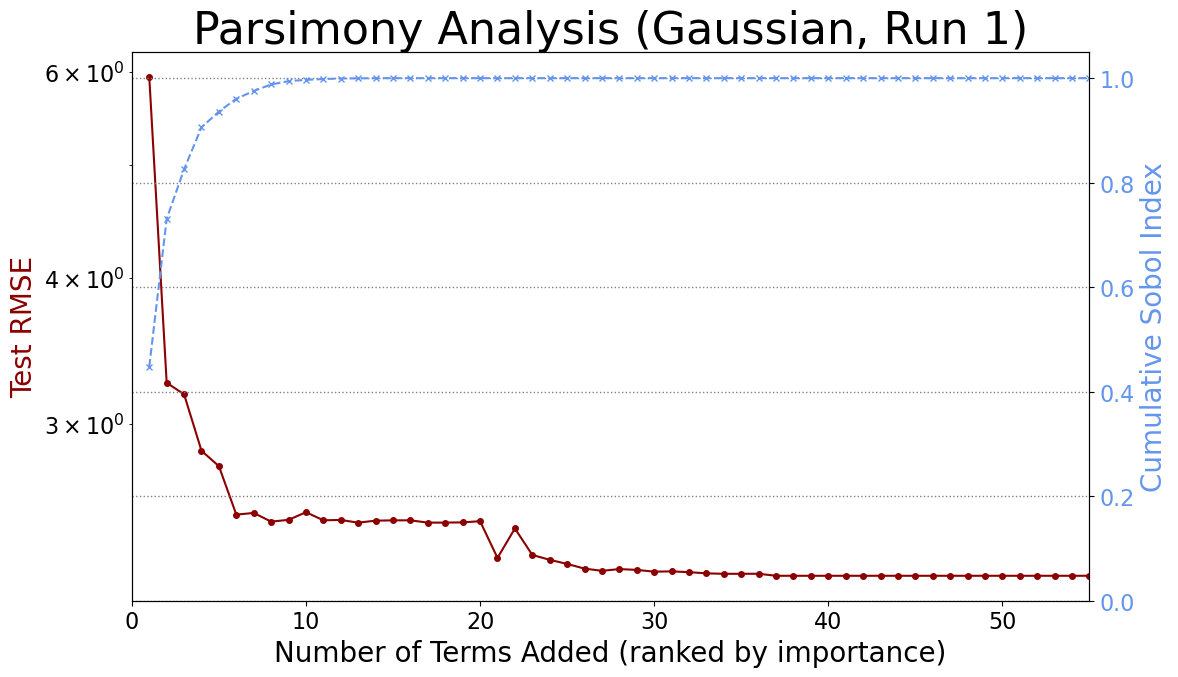

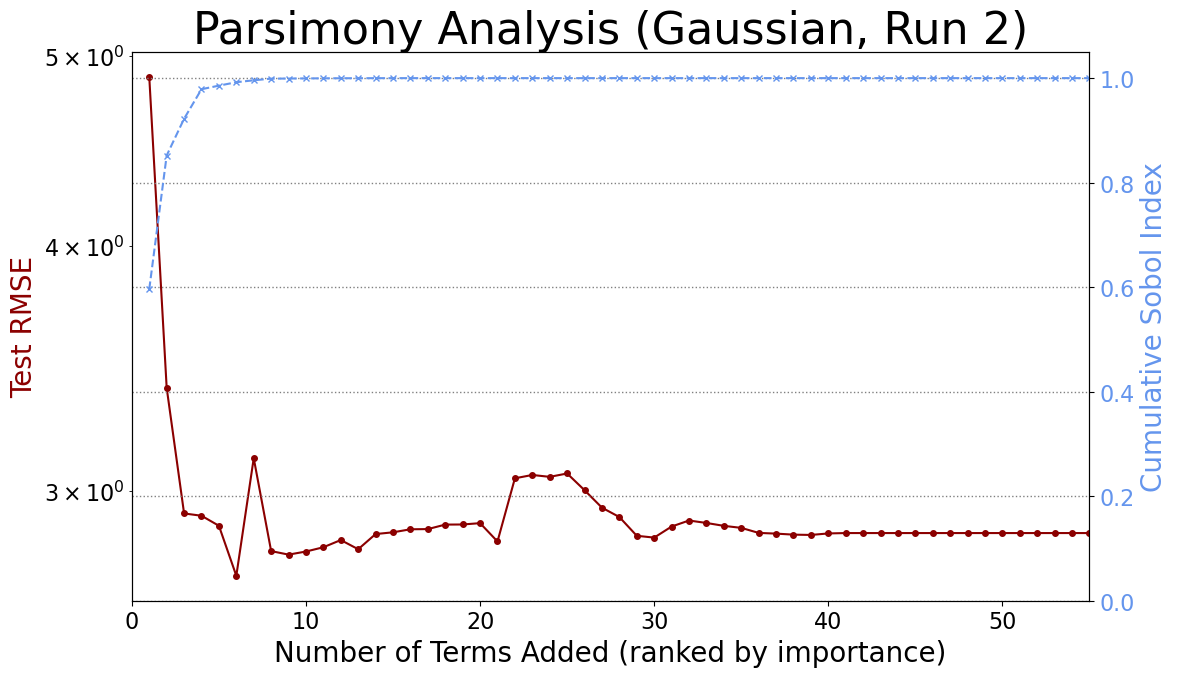

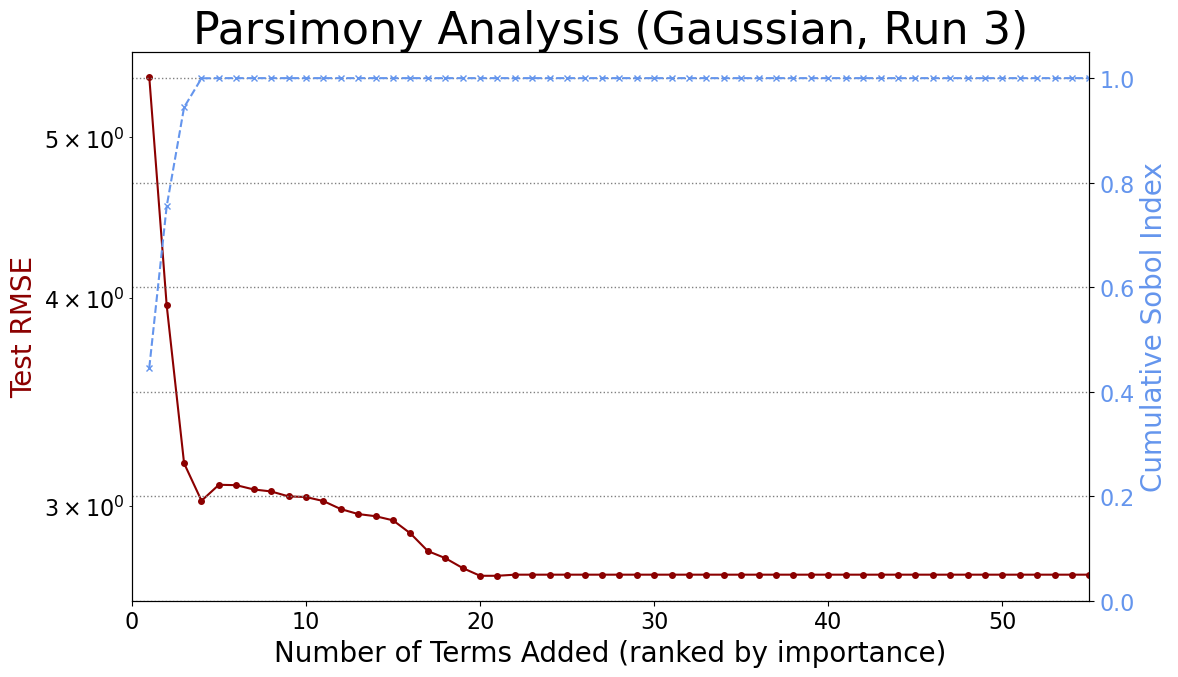

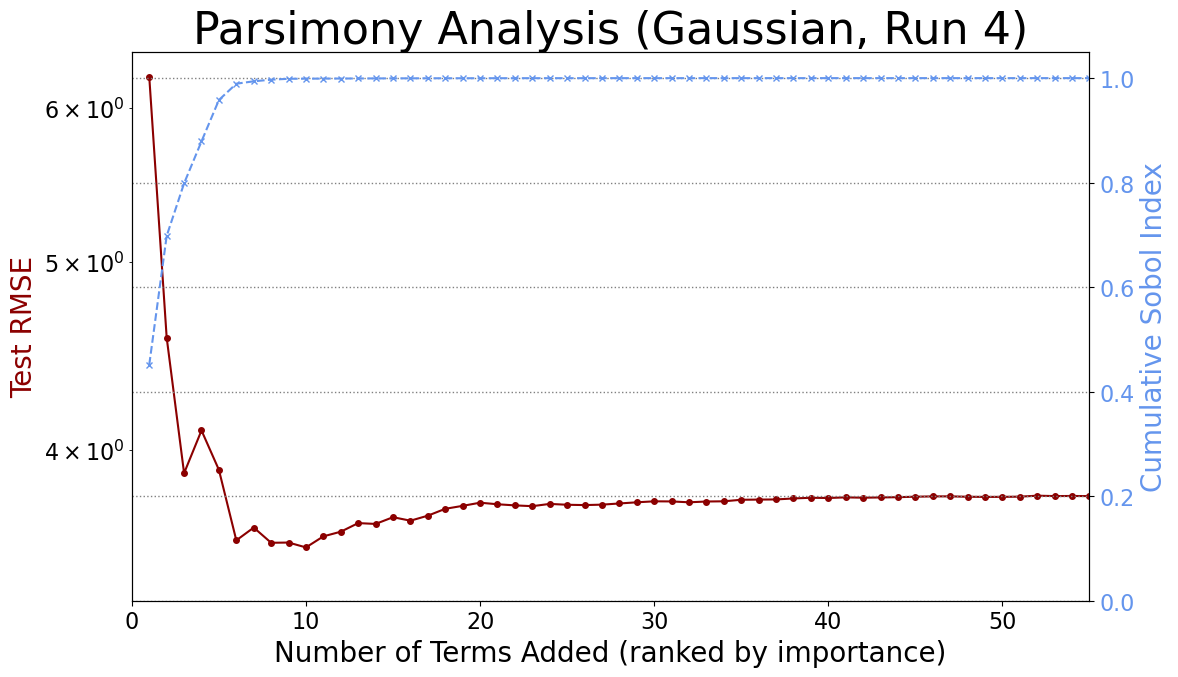

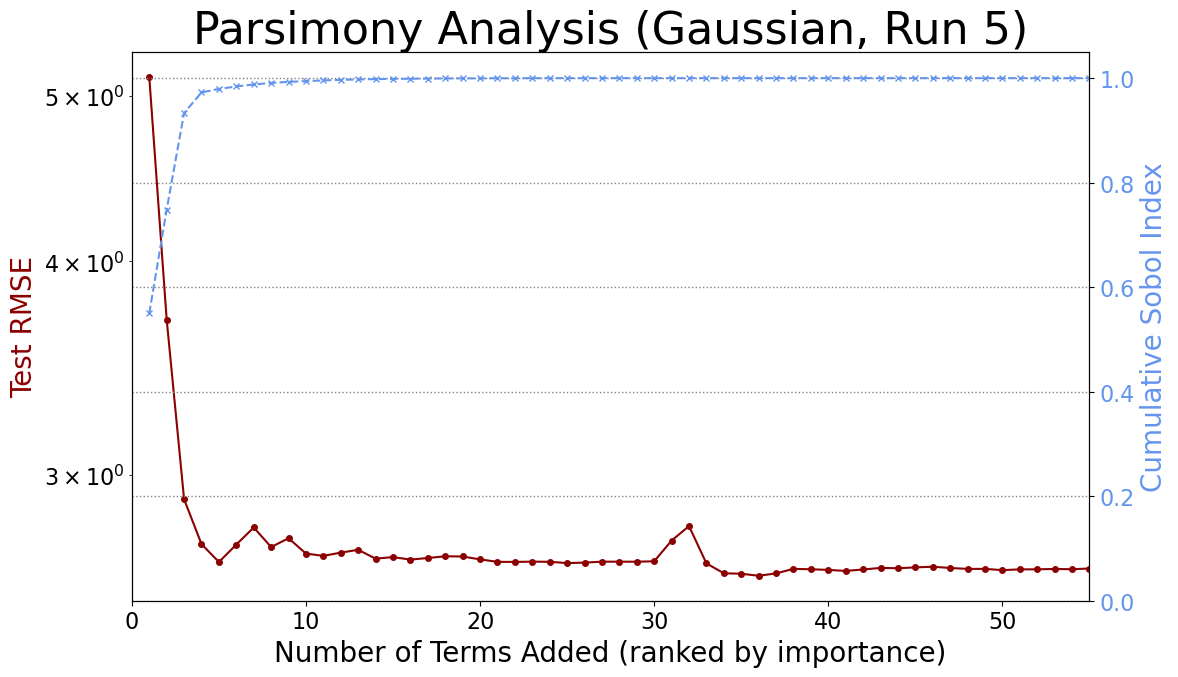

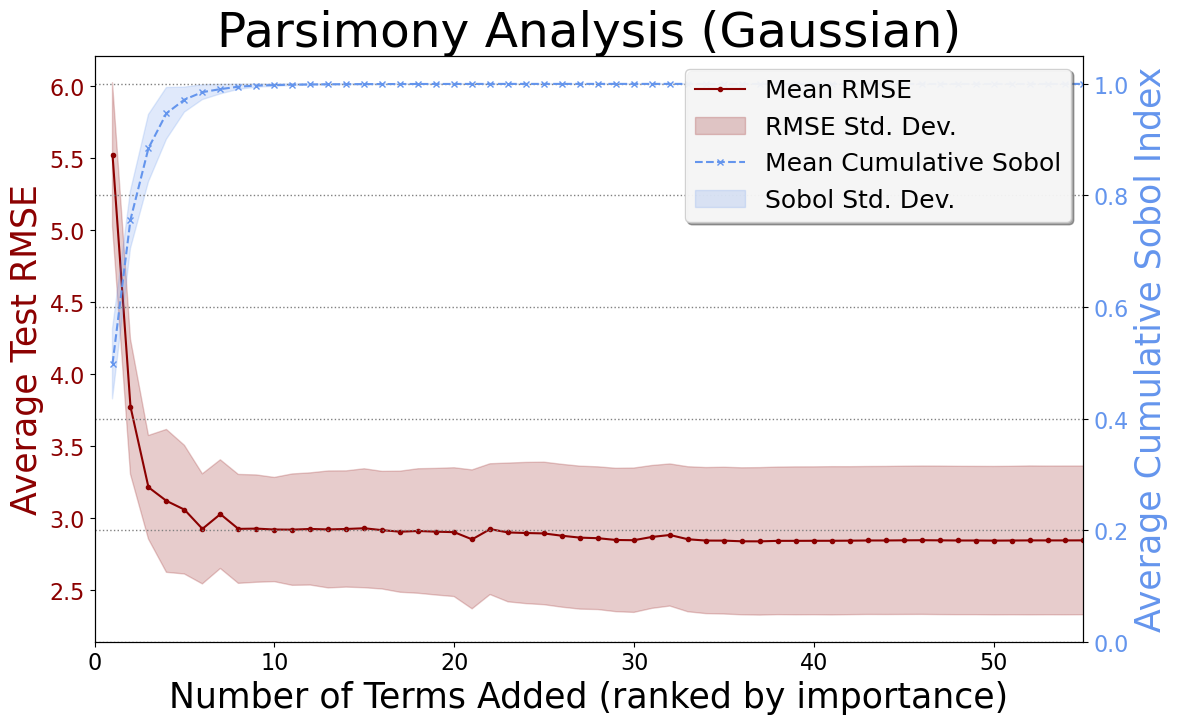

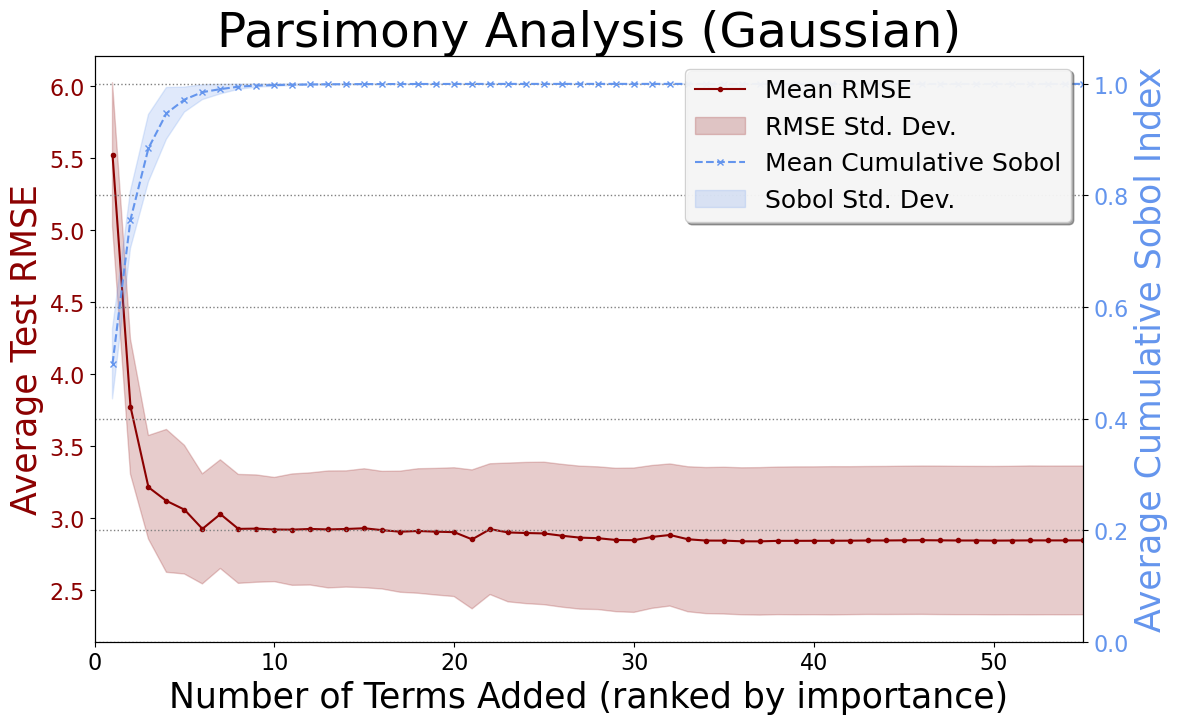

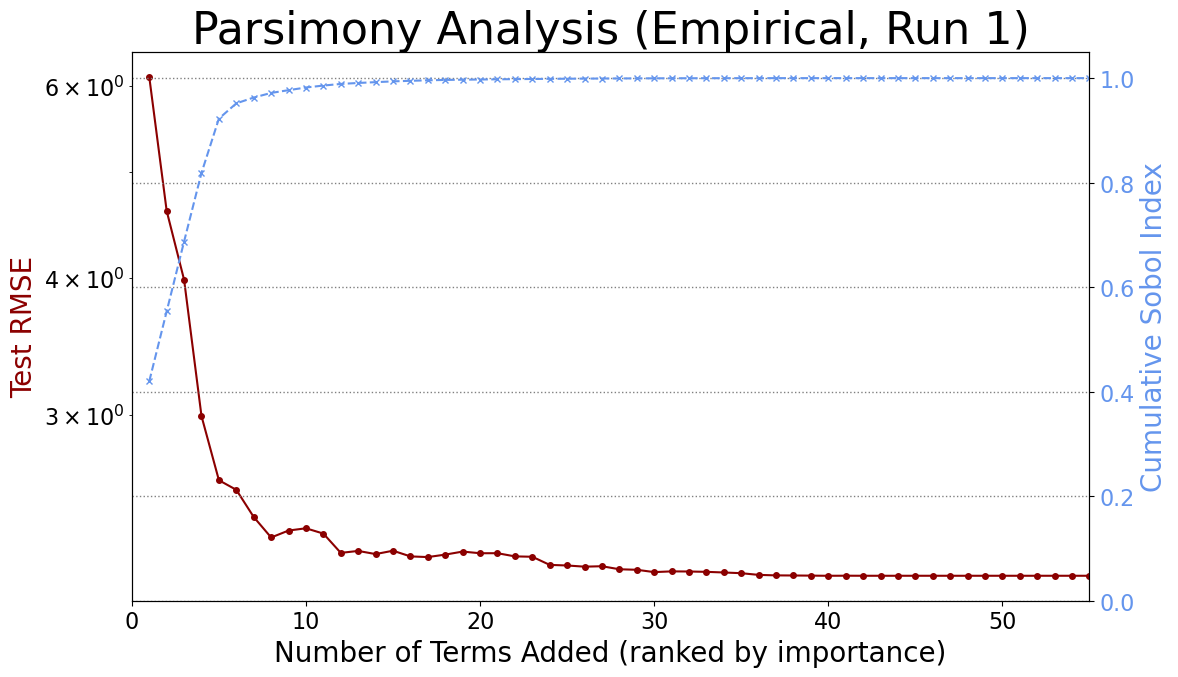

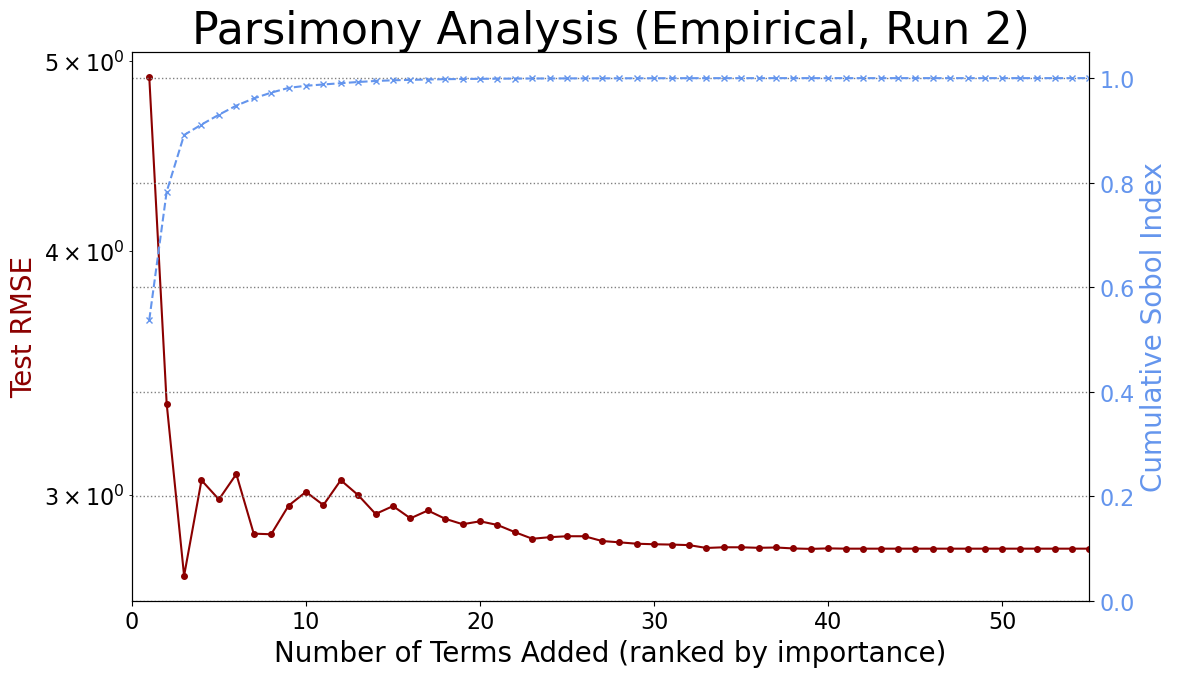

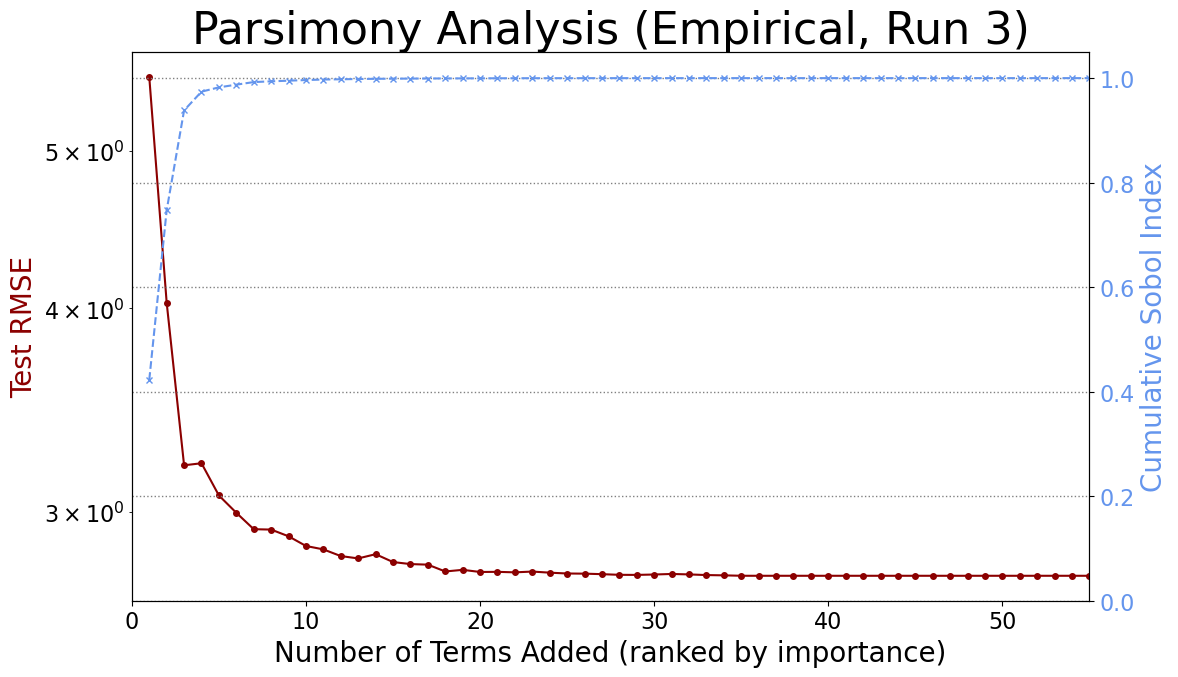

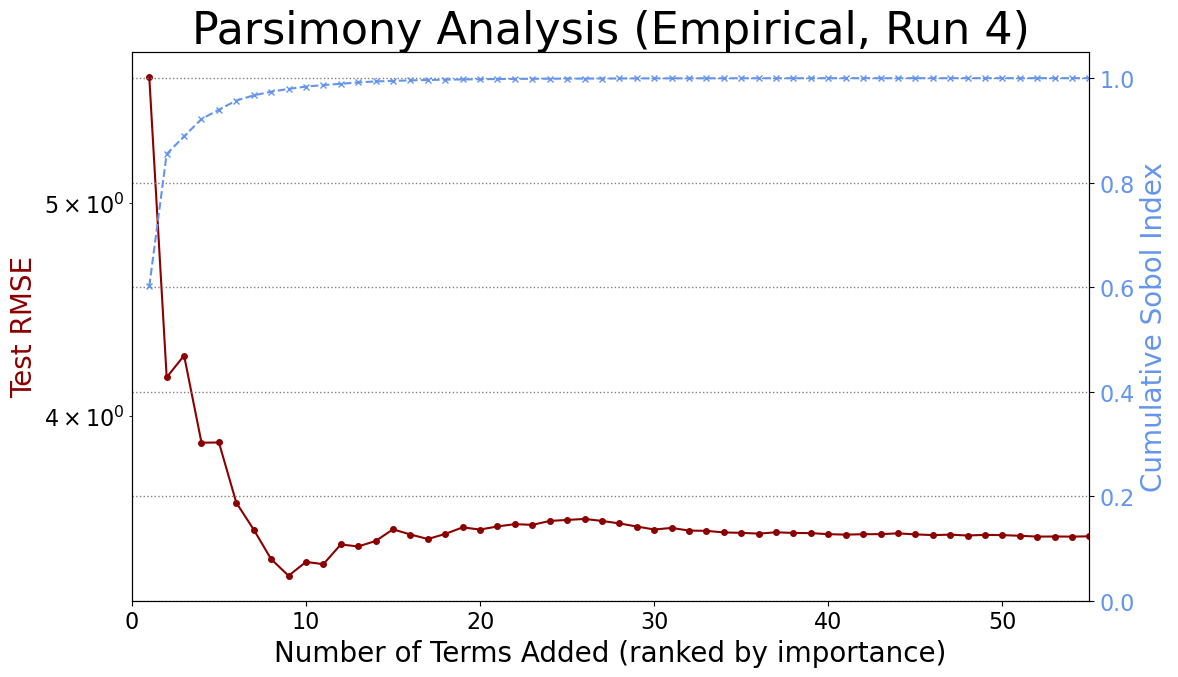

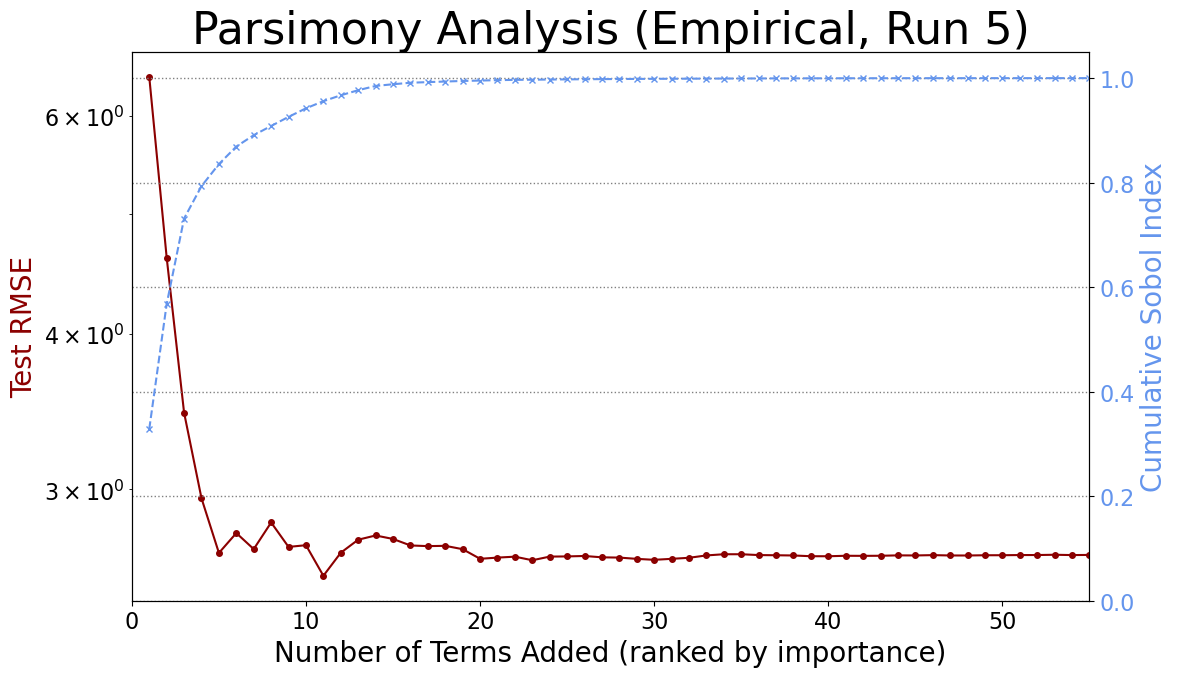

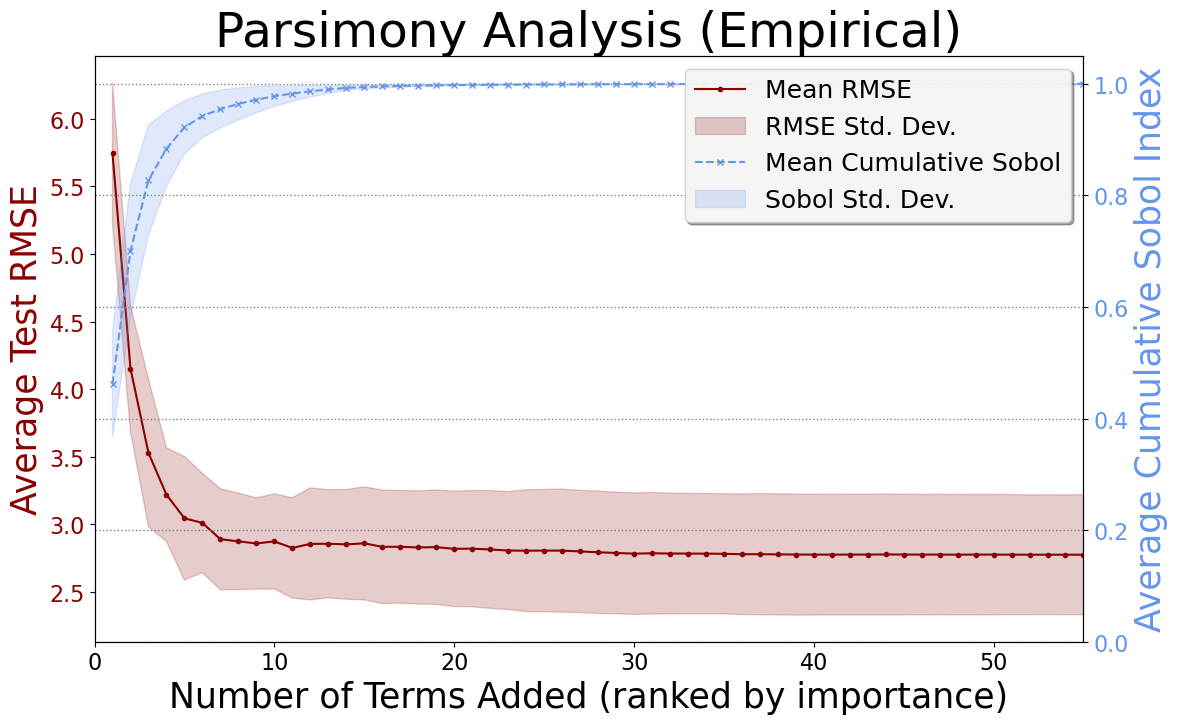

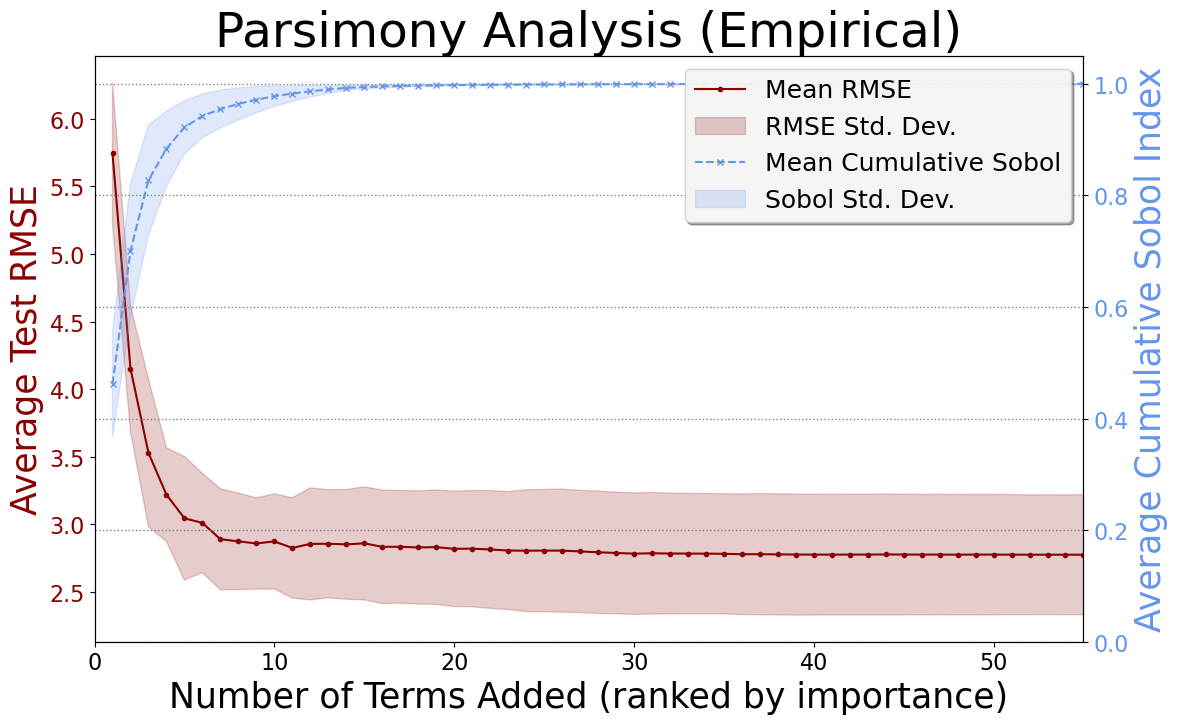

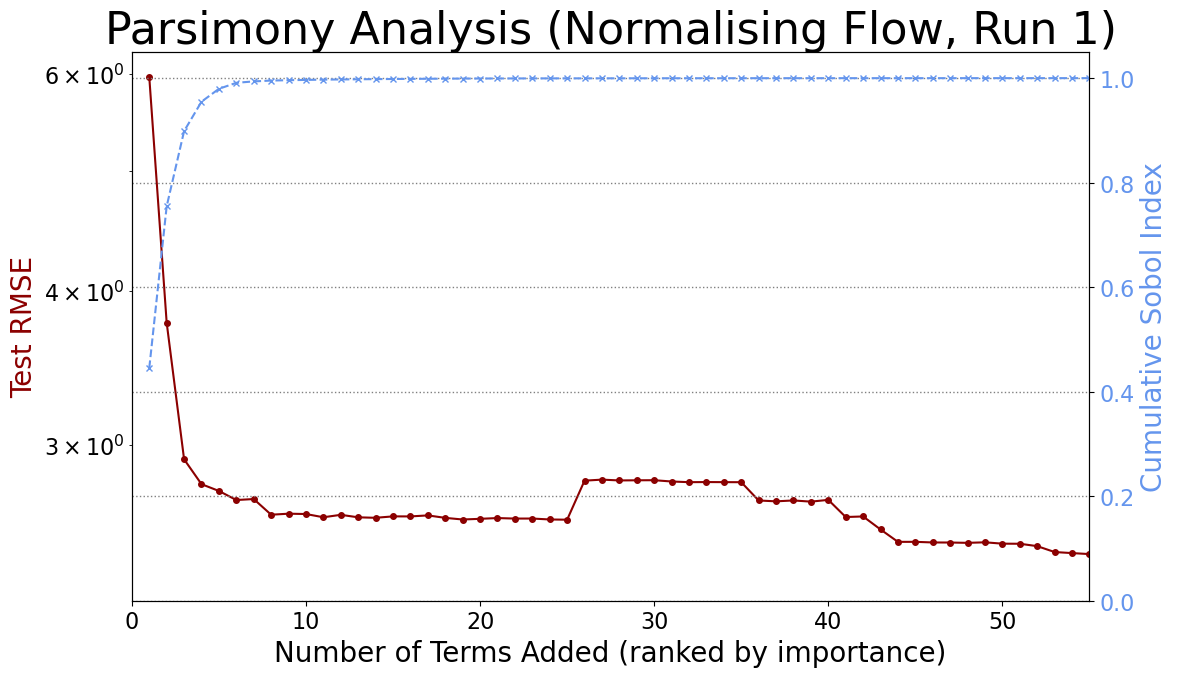

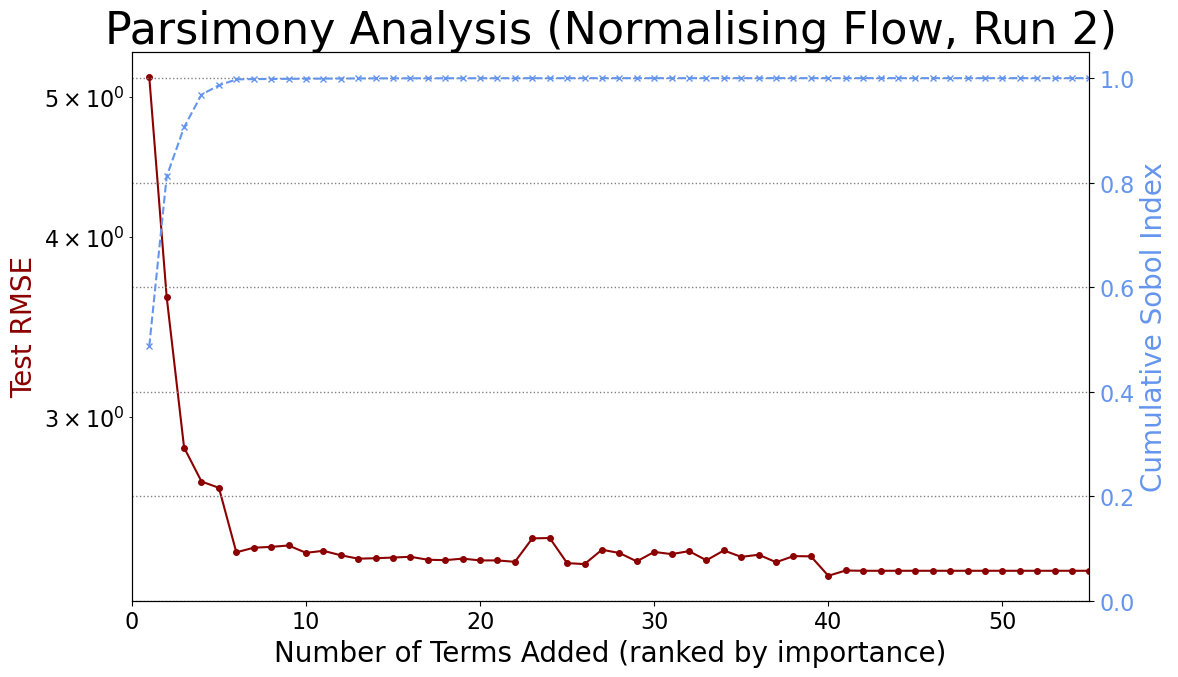

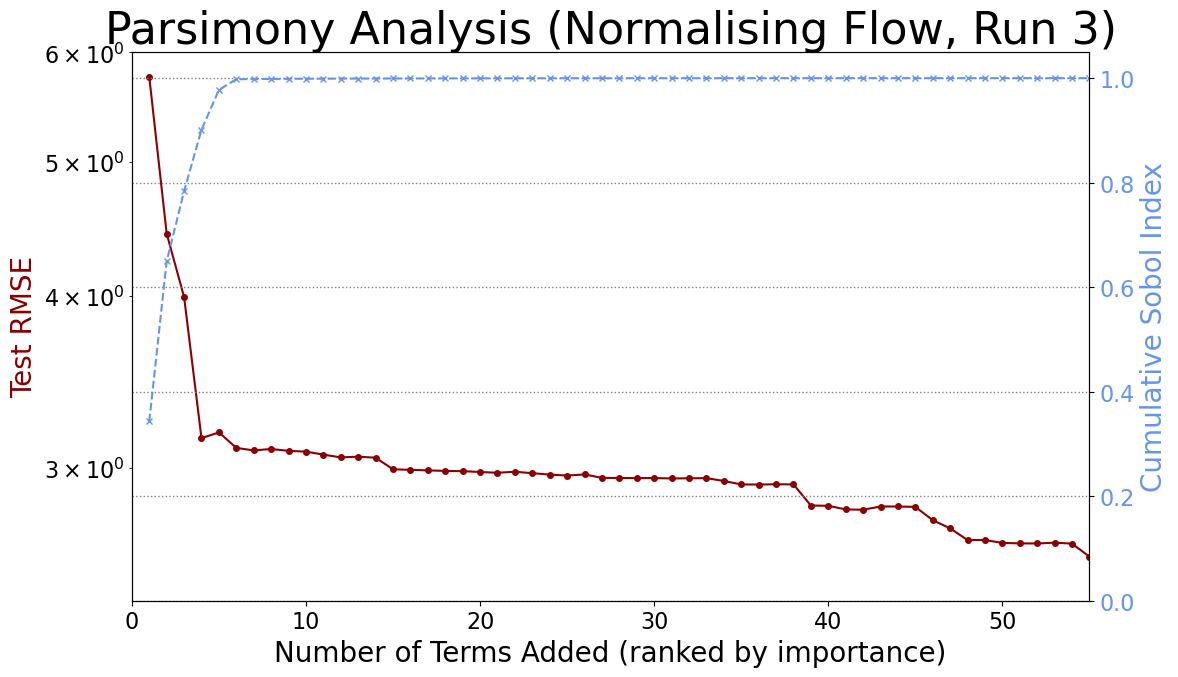

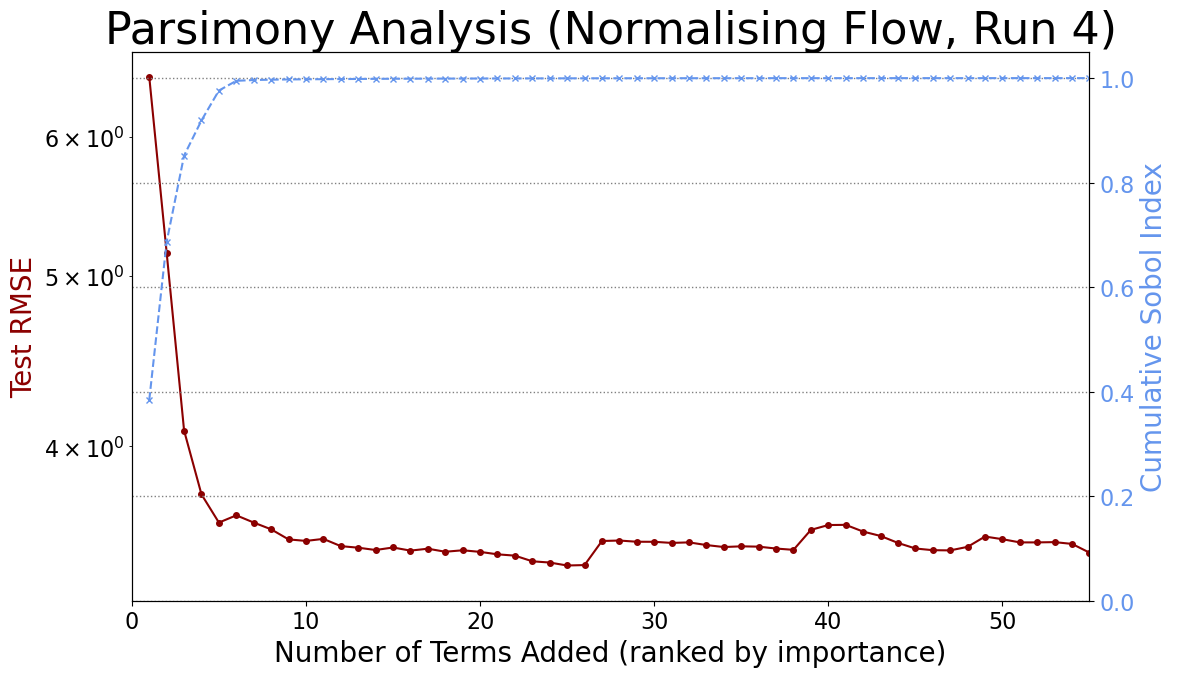

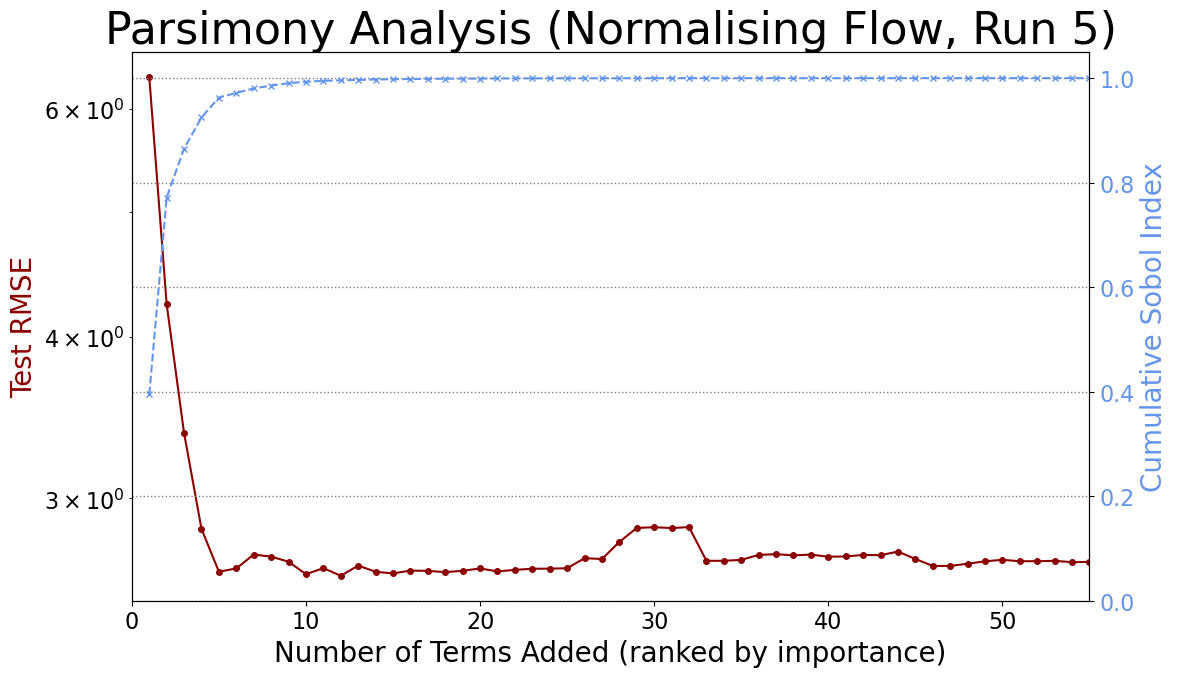

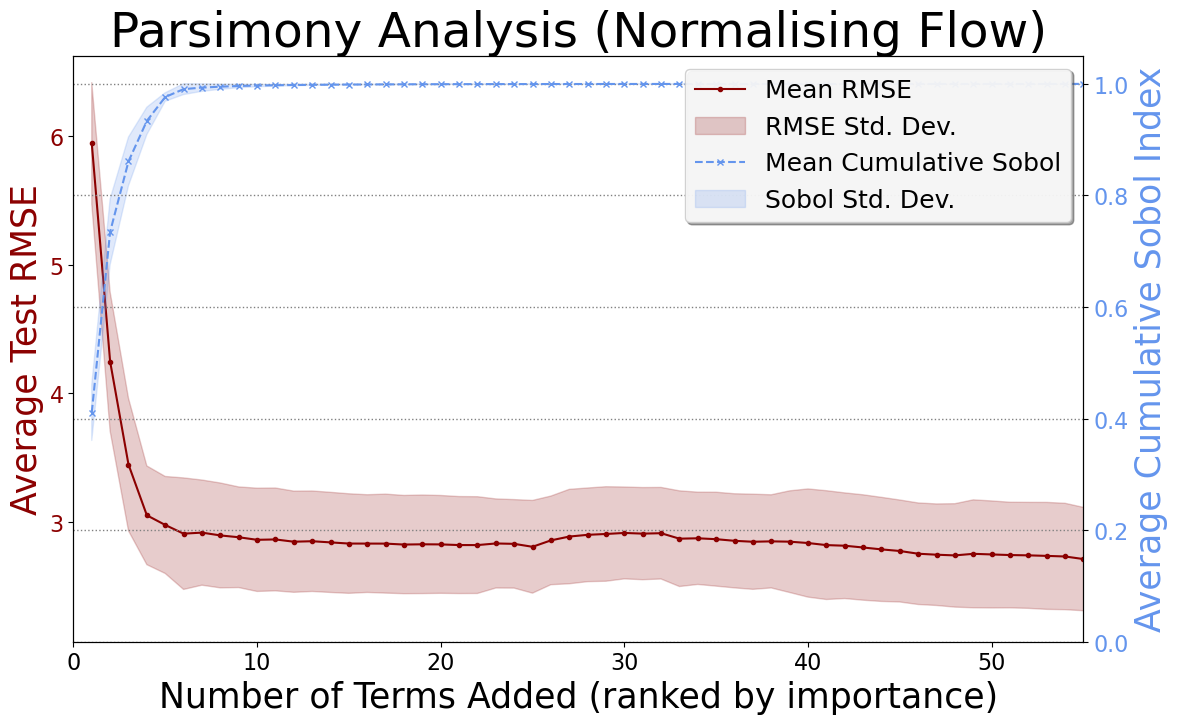

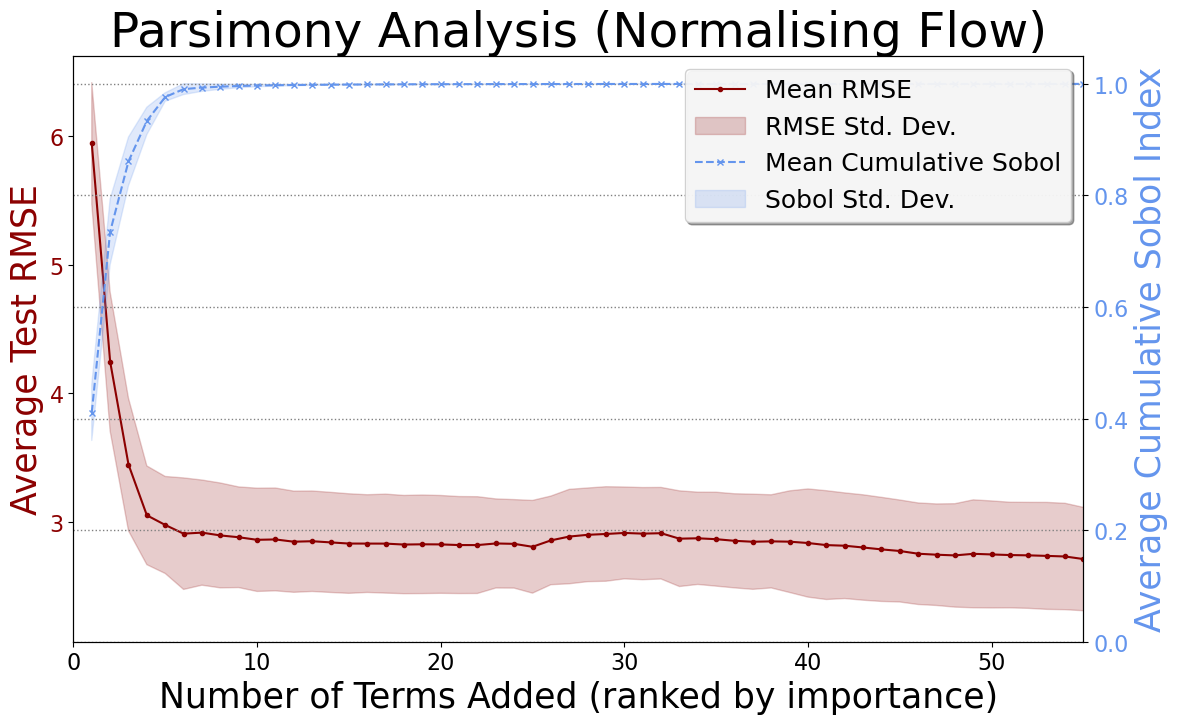

In [146]:
model_titles = {
    "model_3": "Gaussian",
    "model_5": "Empirical",
    "model_6": "Normalising Flow"
}

for model_key, model_results in results.items():
    title_name = model_titles.get(model_key, "Unknown Model")

    # Plot 1: All individual runs on one graph
    plot_parsimony_individual_runs(
        all_sobols=model_results['sobols'],
        all_rmses=model_results['rmses'],
        title=f"Parsimony Analysis ({title_name},"
    )
    plot_parsimony_average(
        all_sobols=model_results['sobols'],
        all_rmses=model_results['rmses'],
        title=f"Parsimony Analysis ({title_name})",
        savefig=f"concreteParsimony{model_key}"
    )
    
    # Plot 2: Averaged run with standard deviation
    plot_parsimony_average(
        all_sobols=model_results['sobols'],
        all_rmses=model_results['rmses'],
        title=f"Parsimony Analysis ({title_name})",
        savefig=f"AutoMpgParsimony{model_key}"
    )